In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-20 21:29:45,422 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

# paths_train = glob('../submit/lb9516/*_train.gz')
# paths_test  = glob('../submit/lb9516/*_test.gz')
# paths_train += glob('../feature/raw_use/is*_train.gz')
# paths_test  += glob('../feature/raw_use/is*_test.gz')
# paths_train += glob('../feature/raw_use/TransactionID_train.gz')
# paths_test  += glob('../feature/raw_use/TransactionID_test.gz')
paths_train = glob('../submit/sub_valid/*_train.gz')
paths_test  = glob('../submit/sub_valid/*_test.gz')
paths_train += glob('../feature/valid_use/*mean_train.gz')
paths_test  += glob('../feature/valid_use/*mean_test.gz')
    
# paths_train = glob('../feature/raw_use/*_train.gz')
# paths_test = glob('../feature/raw_use/*_test.gz')
# paths_train = [path for path in paths_train if filter_feature(path) ]
# paths_test = [path for path in paths_test if filter_feature(path) ]

# paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature = sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  = sorted(glob('../feature/valid_use/*_test.gz'))
paths_train_feature = []
paths_test_feature  = []

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

In [3]:
# df_user_id_bear = pd.read_csv('../output/same_user_pattern/20190901_user_ids_share.csv').set_index(COLUMN_ID)

# df_train.set_index(COLUMN_ID, inplace=True)
# df_train['user_id_bear'] = df_user_id_bear['predicted_user_id']
# df_train.reset_index(inplace=True)

# df_test.set_index(COLUMN_ID, inplace=True)
# df_test['user_id_bear'] = df_user_id_bear['predicted_user_id']
# df_test.reset_index(inplace=True)

2019-09-20 21:30:51,961 func.utils 110 [INFO]    [<module>] * EXP: dataset new_set (590540, 844) lr 0.05  


  * Diff Features: 0
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.923135
[400]	valid_0's auc: 0.92622
Early stopping, best iteration is:
[473]	valid_0's auc: 0.926586


2019-09-20 21:34:16,566 func.utils 140 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.9265863651555771 | Bear's...PB:0.9718229570575025 PV:0.9684760147213091 All:0.9693639015255928 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 197 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.954166
[400]	valid_0's auc: 0.95463
Early stopping, best iteration is:
[434]	valid_0's auc: 0.954853
[  * Fold1 Validation-DT-M 2018-3: 101968] done in 157 s


2019-09-20 21:36:59,034 func.utils 140 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.9548529689644641 | Bear's...PB:0.9749712897237993 PV:0.981564595181543 All:0.9793744513010159 


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.956516
[400]	valid_0's auc: 0.958396
Early stopping, best iteration is:
[475]	valid_0's auc: 0.958927


2019-09-20 21:39:53,758 func.utils 140 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.958927420123164 | Bear's...PB:0.9856205160605345 PV:0.975728346940136 All:0.9793372286350279 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 170 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.949073
[400]	valid_0's auc: 0.950584
Early stopping, best iteration is:
[418]	valid_0's auc: 0.950782


2019-09-20 21:42:41,469 func.utils 140 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9507819512876752 | Bear's...PB:0.9254174123816999 PV:0.9482758771914438 All:0.9408437942438332 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 164 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.961058
[400]	valid_0's auc: 0.963527
[600]	valid_0's auc: 0.963556
Early stopping, best iteration is:
[511]	valid_0's auc: 0.963815


2019-09-20 21:45:35,357 func.utils 140 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9638148565087632 | Bear's...PB:0.9748264022906465 PV:0.977985134845928 All:0.9767529360635321 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 170 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.965805
[400]	valid_0's auc: 0.967327
[600]	valid_0's auc: 0.96741
Early stopping, best iteration is:
[512]	valid_0's auc: 0.967722


2019-09-20 21:48:50,754 func.utils 140 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9677219845615078 | Bear's...PB:0.969789782585718 PV:0.9679826438713254 All:0.9684995643942061 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 191 s
[  * Make Prediction Result File.] done in 49 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.9205166974717448
  *  (506691,) (506691,)
  * LB0.95169 / 0.971699787591332
  *  (506691,) (506691,)
  * LB0.9518 / 0.9534825503387679
  *  (506691,) (506691,)
  * LB0.9529 / 0.9462064425059892
  *  (506691,) (506691,)
  * LB0.9542 / 0.9061254632954602
* CV: 0.9537809244335252 | BestIter: 470.5
* Training Feature Importance


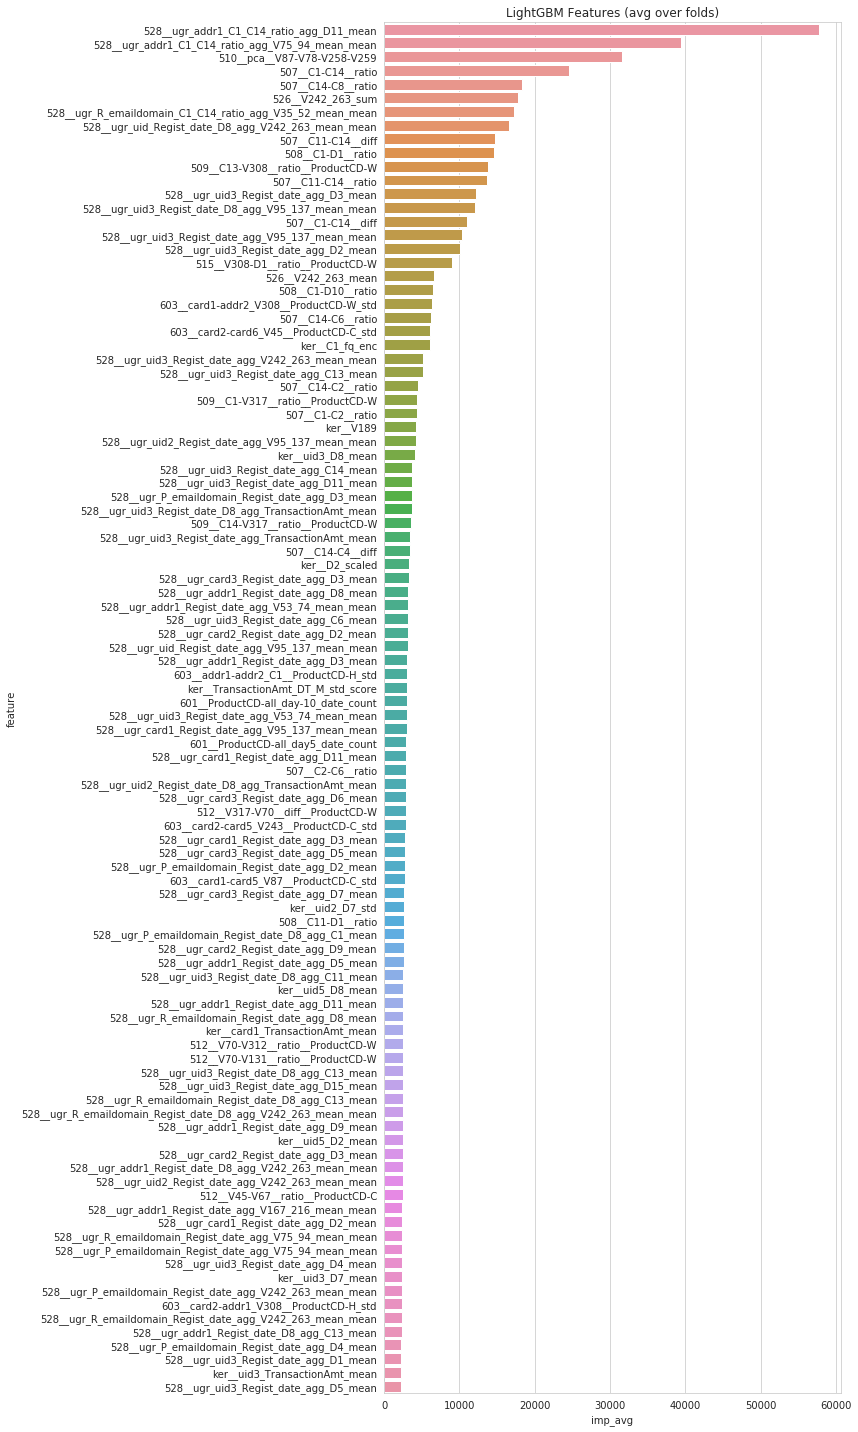

Setup Dataset dim_ml_dataset.


In [4]:
is_submit = [True, False][0]
has_dec = [True, False][0]
n_splits = 6
set_type = 'new_set'

valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

if len(valid_paths_train):
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
else:
    tmp_train = df_train
    tmp_test = df_test

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group

# 2017-12抜いてみる
# if not has_dec:
#     tmp_train = tmp_train[tmp_train[COLUMN_GROUP]!='2017-12']
#     Y = Y.loc[tmp_train.index]
#     n_splits = 5


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 60,
    'n_jobs': 96,
#     'n_jobs': 48,
#     'n_jobs': 36,
    'objective': 'binary',
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.30,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
    "seed": 1208,
    "bagging_seed": 1208,
    "feature_fraction_seed": 1208,
    "drop_seed": 1208,
    'n_splits': n_splits,
    'metric': 'auc',
    'model_type': model_type,
    'fold': ['stratified', 'group'][1],
}
if is_submit:
    params['learning_rate'] = 0.01
    params['learning_rate'] = 0.05
    params["early_stopping_rounds"] = 100

logger.info(f"* EXP: dataset {set_type} {tmp_train.shape} lr {params['learning_rate']} ")

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [7]:
feim = list_result_feim[0]

In [11]:
# sub = pd.read_csv('../submit/lb/20190909_2324__CV0-9467296784440689__feature552.csv')
# sub = pd.read_csv('../submit/lb/20190917_0022__CV0-947676__BearAUC0-9631.csv')
# sub = pd.read_csv('../submit/tmp/20190917_0825__CV0-9486992730843505__feature750.csv')
# sub = pd.read_csv('../submit/tmp/20190917_0947__CV0-9454660522014052__feature750.csv')
# sub = pd.read_csv('../submit/tmp/20190917_1107__CV0-9485055333319241__feature686.csv')
sub = pd.read_csv('../submit/tmp/20190920_1002__CV0-9505750228407942__feature994.csv')
sub[COLUMN_ID] = sub[COLUMN_ID].astype('int')
sub.head()

,TransactionID,isFraud
0,3663549,0.000495
1,3663550,0.000919
2,3663551,0.000627
3,3663552,0.000943
4,3663553,0.000530


In [12]:
from sklearn.metrics import roc_auc_score
bear = pd.read_csv('../input/20190913_ieee__bear_probing.csv').iloc[:, [0, 3, 4, 6]]
bear = bear[bear[COLUMN_TARGET]==-1]
bear = bear.iloc[:, [0,1,3]]
sub.columns = [COLUMN_ID, 'pred']
bear.columns = [COLUMN_ID, 'data_type', COLUMN_TARGET]
bear_score = sub.merge(bear, how='inner', on=COLUMN_ID)
public = bear_score[bear_score['data_type']=='test_public']
private = bear_score[bear_score['data_type']=='test_private']


public_score = roc_auc_score(public[COLUMN_TARGET].values, public['pred'].values)
private_score = roc_auc_score(private[COLUMN_TARGET].values, private['pred'].values)
all_score = roc_auc_score(bear_score[COLUMN_TARGET].values, bear_score['pred'].values)
print(public_score, private_score, all_score)

0.9693337434518601 0.9597681288570636 0.9637032059110936


In [2]:
feim = read_pkl_gzip('../output/feature_importances/20190920_1351__CV0-9534658757641309__feature1190.gz')
# pd.set_option('max_rows', 200)
# feim = list_result_feim[0]
print(feim.shape)
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(50)
# feim.loc[[i for i in feim.index if i.count('browser')]]

(1190, 7)


,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__V242,47.774681,4.338970,157.266205,25.605141,16.049654,41.456802,48.748577
526__V226_230_max,22.176426,55.315231,53.842461,34.148781,29.509571,95.777603,48.461674
526__V3_4_5_9_11_std,37.532028,50.733662,95.086105,12.702540,42.304096,50.577877,48.156052
526__V35_52_sum,52.651798,61.228378,20.721521,21.287121,56.446484,75.927711,48.043839
515__V281-D7__ratio__ProductCD-C,18.076248,44.716400,58.564159,120.377441,11.641709,33.174541,47.758419
ker__C7_fq_enc,41.392582,18.879320,8.857655,124.174248,47.684486,40.963020,46.991882
526__V2_11_std,36.242226,45.175713,43.775230,10.490940,59.599934,60.088589,42.562107
526__V53_74_pro,41.066399,9.237090,35.865799,100.957336,0.000000,32.664398,36.631836
516__P_emaildomain_bin_anonymous_dummie,10.870800,82.834084,54.781380,0.000000,45.428070,2.191230,32.684261


In [3]:
feim[feim['imp_avg']<500].shape

(238, 7)

In [4]:
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim[feim['imp_avg']<1000].index:
# for feature_name in feim.index:
#     if not feature_name.count('ker'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'raw_use'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = 'valid_use'
#     from_dir = 'org_use'
    to_dir = 'valid_trush'
#     to_dir = 'raw_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
#     to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

601__ProductCD-all_day-10_date_count
528__ugr_P_emaildomain_Regist_date_agg_D11_mean
528__ugr_addr1_Regist_date_agg_D15_mean
ker__uid3_D2_mean
ker__D8_DT_D_min_max
528__ugr_R_emaildomain_Regist_date_agg_V53_74_mean_mean
528__ugr_addr1_Regist_date_D8_agg_V53_74_mean_mean
528__ugr_addr1_Regist_date_agg_C10_mean
528__ugr_P_emaildomain_Regist_date_agg_V3_4_5_9_11_mean_mean
528__ugr_card2_Regist_date_agg_C13_mean
603__card4-addr1_V317__ProductCD-H_std
603__card5-addr1_V308__ProductCD-R_std
528__ugr_uid2_Regist_date_agg_D11_mean
528__ugr_addr1_Regist_date_agg_D14_mean
528__ugr_R_emaildomain_Regist_date_agg_D2_mean
ker__uid4_TransactionAmt_std
528__ugr_uid3_C1_C14_ratio_agg_D7_mean
528__ugr_uid3_C1_C14_ratio_agg_V167_216_mean_mean
508__C1-D4__ratio
528__ugr_uid3_Regist_date_agg_C2_mean
ker__uid4_D11_std
ker__uid2_D6_mean
ker__uid2_D11_std
ker__uid2_TransactionAmt_mean
603__card2-addr1_V315__ProductCD-W_std
603__card2-addr1_C11__ProductCD-S_std
603__card1-addr2_V317__ProductCD-W_std
603__card4